In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import re
import regex
from collections import Counter

import matplotlib.pyplot as plt

from wordcloud import WordCloud

### Data observation

> Retrieve the song data from the file provided

In [2]:
songs_df = pd.read_csv('Songs.csv', header = 0)
songs_df.head(5)

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


> Each entry ends with something like '1EmbedShare URLCopyEmbedCopy', so we removed those appearances from the lyrics.

In [3]:
songs_df['Lyrics'] = songs_df['Lyrics'].str.replace(r'\d+EmbedShare URLCopyEmbedCopy$', "", regex=True)

> Show all unique artists in the dataset

In [4]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 30 Songs
​twenty one pilots: 30 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 30 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> The dataset's size.

In [5]:
print(f'The dataset contains {len(songs_df)} entries for songs.')

The dataset contains 745 entries for songs.


> The dataset contains 3 duplicates so we will need to take care of that.

In [6]:
print(f'The dataset contains {len(songs_df['Title'].unique())} unique songs.')

The dataset contains 742 unique songs.


> Cleanup of duplicates

In [7]:
songs_df = songs_df.drop_duplicates(subset='Title')

In [8]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 29 Songs
​twenty one pilots: 29 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 29 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> Average song length (characters & words)

In [9]:
lengths = songs_df['Lyrics'].apply(lambda x: len(x.split()))
avg_words = lengths.sum() / songs_df['Lyrics'].nunique()

char_lengths = songs_df['Lyrics'].apply(lambda x: len(x))
avg_chars = char_lengths.sum() / songs_df['Lyrics'].nunique()

print(f'The average number of words in a song is {avg_words:.2f}')
print(f'The average number of characters in a song is {avg_chars:.2f}')

The average number of words in a song is 275.94
The average number of characters in a song is 1388.24


> Word Cloud

> First we checked for abnormal characters we wanted to remove

In [10]:
# Combine all lyrics into one large text
all_lyrics = " ".join(songs_df["Lyrics"].dropna())

# Clean the text (remove punctuation, convert to lowercase)
all_lyrics = re.sub(r"[^\w\s]", "", all_lyrics.lower())

In [11]:
print(set(all_lyrics))

{'0', 'í', 't', '\u2005', 'ç', 'ã', ' ', '\u205f', 'ŏ', 'ä', 'd', 'ü', 'x', 'ا', 'h', 'ل', 'y', '\u200a', '6', 'c', 'm', 'z', 'g', 'r', 's', 'k', 'ñ', 'è', 'l', 'j', '1', 'á', 'س', 'م', '9', 'ó', 'i', '3', 'ö', 'é', '\n', 'p', 'v', 'е', 'w', '5', 'e', '8', 'و', 'n', 'b', 'à', 'q', '7', 'ê', 'o', 'u', '4', 'a', 'ë', 'f', '2'}


> Tokenize and remove words that contain characters that are not latin or digits

In [12]:
# Tokenization and cleaning
words = all_lyrics.split()

# \p{L} matches any letter in any language
# \p{N} matches any numeric character
words = [word for word in words if regex.fullmatch(r"[\p{Latin}\p{N}]+", word)]

> Set up the WordCloud

The 3 most common words are:
the: 8124 appearances
you: 7105 appearances
i: 6872 appearances


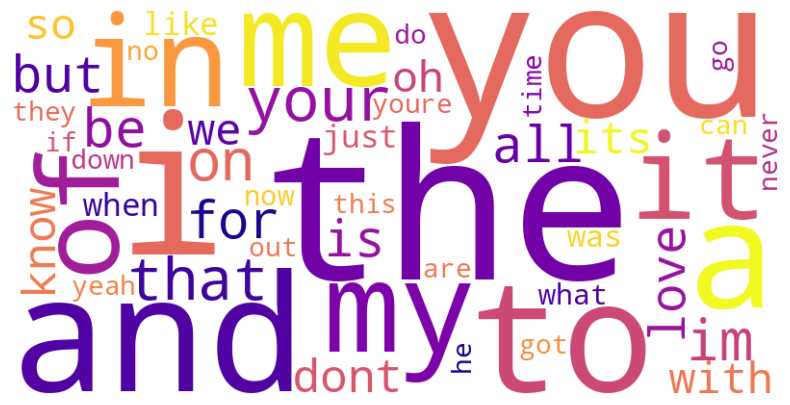

In [13]:
# Retrieve word frequencies
word_counts = Counter(words)

# 3 most common words
print("The 3 most common words are:")
for word, count in word_counts.most_common(3):
    print(f"{word}: {count} appearances")

# Definition of wordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='plasma', max_words=50).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Preprocessing

> Build a corpus and encode it for training

In [16]:
lyrics = songs_df["Lyrics"].dropna().str.lower()

# Remove words with unwanted characters
tokenized_lyrics = [
    [word if word != '\n' else '<newline>' for word in regex.findall(r"[\p{Latin}\p{N}]+|\n", lyric)]
    for lyric in lyrics
]

# Build vocabulary
word_counts = Counter(word for song in tokenized_lyrics for word in song)
word_to_index = {word: i + 1 for i, (word, _) in enumerate(word_counts.items())}
index_to_word = {i: word for word, i in word_to_index.items()}

# Vocabulary size
vocab_size = len(word_to_index) + 1  # Adding 1 for padding if needed

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 9062


> We printed the filtered characters, only words with these characters are considered

In [17]:
all_chars = "".join(word for lyric in tokenized_lyrics for word in lyric)
print(sorted(set(all_chars)))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ']


In [19]:
# Convert lyrics to numerical sequences, instead of words it is now numbers (indices)
encoded_sequences = [[word_to_index[word] for word in song if word in word_to_index] for song in tokenized_lyrics]

# Set sequence length (choose a reasonable length)
# This is the number of words that the model will use to predict the next word
SEQ_LENGTH = 20

# Create input-target pairs
input_sequences = []
targets = []

# Construct all sequences and their targets
for song in encoded_sequences:
    for i in range(1, len(song)):
        n_gram_sequence = song[:i+1]                        # Create sequence up to current word
        if len(n_gram_sequence) >= 2:                       # Ensure sequence has at least one input and one target
            input_sequences.append(n_gram_sequence[:-1])    # All but last word (input)
            targets.append(n_gram_sequence[-1])             # Last word (target)

# Pad sequences to the same length (max length)
# we use 0 for padding since the indices start from 1
max_seq_length = SEQ_LENGTH
padded_sequences = [([0] * (max_seq_length - len(seq)) + seq)[-max_seq_length:] for seq in input_sequences]

# Convert to tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.long)

class SongLyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
dataset = SongLyricsDataset(X, y)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Dataset Size: {len(dataset)}")

Dataset Size: 251120


In [20]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=256, num_layers=4):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Get output from last LSTM step
        return out

# Model setup
model = LyricsLSTM(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# GPU utilization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LyricsLSTM(
  (embedding): Embedding(9062, 256)
  (lstm): LSTM(256, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=9062, bias=True)
)

> Train for 100 Epochs as requested

In [21]:
EPOCHS = 100

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    train_losses.append(avg_loss)  # Save the average loss for this epoch
    if epoch%5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(data_loader):.4f}")


Epoch 1/100, Loss: 5.6944
Epoch 6/100, Loss: 3.2612
Epoch 11/100, Loss: 2.2181
Epoch 16/100, Loss: 1.6066
Epoch 21/100, Loss: 1.2263
Epoch 26/100, Loss: 0.9835
Epoch 31/100, Loss: 0.8297
Epoch 36/100, Loss: 0.7261
Epoch 41/100, Loss: 0.6544
Epoch 46/100, Loss: 0.6115
Epoch 51/100, Loss: 0.5730
Epoch 56/100, Loss: 0.5488
Epoch 61/100, Loss: 0.5299
Epoch 66/100, Loss: 0.5108
Epoch 71/100, Loss: 0.4938
Epoch 76/100, Loss: 0.4919
Epoch 81/100, Loss: 0.4883
Epoch 86/100, Loss: 0.4749
Epoch 91/100, Loss: 0.4666
Epoch 96/100, Loss: 0.4679


In [22]:
torch.save(model.state_dict(), 'lyrics_lstm_weights.h5')

> Plot the training loss

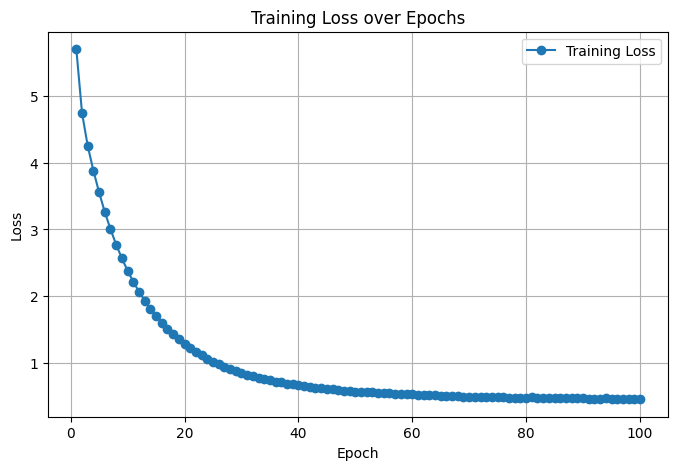

In [23]:
# Plotting the training loss after training completes
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def LyricsGenerator(starting_string, model, word_to_index, index_to_word, max_words=avg_words, strategy="", k= 10, p = 0.9):
    model.eval()
    max_words = int(max_words)
    
    if not starting_string.strip():
        starting_word = random.choice(list(word_to_index.keys()))
        words = [starting_word]
    else:
        words = starting_string.lower().split()
    
    for _ in range(max_words):
        # Convert words to indices
        encoded_input = [word_to_index.get(word, 0) for word in words][-SEQ_LENGTH:]
        input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)

        # Predict next word
        with torch.no_grad():
            output = model(input_tensor)
            output = output.squeeze(0)

            probabilities = torch.softmax(output, dim=-1).cpu().numpy()

            if strategy == "top-k":
                top_k_indices = probabilities.argsort()[-k:][::-1]
                top_k_probs = probabilities[top_k_indices]
                top_k_probs = top_k_probs / top_k_probs.sum()  # Normalize to make it a valid probability distribution
                predicted_index = np.random.choice(top_k_indices, p=top_k_probs)
            elif strategy == "top-p":
                sorted_indices = np.argsort(probabilities)[::-1]
                cumulative_probs = np.cumsum(probabilities[sorted_indices])
                top_p_indices = sorted_indices[cumulative_probs <= p]

                if len(top_p_indices) == 0:  # If no words remain, default to the word with highest probability
                    top_p_indices = [sorted_indices[0]]

                top_p_probs = probabilities[top_p_indices]
                top_p_probs = top_p_probs / top_p_probs.sum()  # Normalize to make it a valid probability distribution
                predicted_index = np.random.choice(top_p_indices, p=top_p_probs)
            else:
                predicted_index = np.argmax(probabilities)

        # Convert index to word
        next_word = index_to_word.get(predicted_index, "<UNK>")
        words.append(next_word)

    return " ".join(words)


#### Using top-k strategy

In [41]:
seed = "it's not a silly little moment"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-k", k=10)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 it's not a silly little moment for me 
 until the whole new scene plays down for a man 
 give him the fire turn up the bricks the kids 
 
 next one shots baby 
 i got a bad boy persona that s why they like 
 a big kisses in your hair 
 it s there up where you met 
 
 
 well i ve made a thing that i d tell you yeah 
 you will hold your hand 
 i wanna go with you 
 i m just a fire 
 i m not your father 
 then you tolerate to me 
 when you re looking for 
 giving me to sing 
 and lay for a day 
 i haven t come down 
 
 leave my plans i m starving 
 won t believe what i m asking to 
 and i can see her everything it seems 
 think my heart is breaking 
 my neck she must shouldn 
 i could speak the words 
 we do we would tell you all that i give when to live 
 it s easier like these though there were ghosts to tell them 
 one calypso a smile why wait for the thought to 
 no you can ring with me 
 
 woah oh children 
 always re comin at the future 
 well now baby now we ve 

In [33]:
seed = "There is a house in"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-k", k=10)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 there is a house in a very kid 
 and is its new four o 
 father lives in year he sat by shelter s lies 
 down up a kansas farmboy 
 their handful left their hands and well 
 but one i ll be on and again 
 i ve been getting ready 
 but so am i lay down this town 
 won t stop over this pain 
 would i tell him i need ya 
 jazz in the room with a neighborhood violin 
 there was something things seems so high 
 now the word is as his stardust skin 
 i wanna pay a lullaby 
 
 say my name 
 i m going down to the crossroads 
 tried to flag a ride 
 rocky mountain high in colorado 
 rocky mountain high 
 
 all all over in the air 
 i can t believe what can t understand 
 please forgive me i can t stop loving you 
 
 
 it ain t easy it ain t easy 
 it ain t easy but it ain t sad it don t feel so right 
 you re talking for this moment and you into a brand fool 
 don t act like an too city too much 
 you ve been a naughty boy why didn t much the best 
 
 cause god did 
 take me

In [34]:
seed = ""
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-k", k=10)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 poachers man of life of time 
 and now the dark surrenders over with the wind 
 for the rainbow and the song is dead through 
 and he never gave good by white 
 fall as a window smile like a saturday night 
 they re sharing hard to lose it were the last one 
 then doesn t come with your fear and loves me and you 
 either one of us is hard to blame for it 
 wait for me to believe our will get a sea 
 our kisses lasts at all 
 the better things i need to know 
 they know these people now you re still at all 
 
 i wish all you would give him the weather 
 like these make for a reason for that little matter in my mouth 
 it s in your eyes and i held it a room 
 don t leave the curtains told me 
 everything is good 
 oh darling we ve been around my heart 
 well i liked it too far 
 to live in a style 
 baby it s seen the road to the lookout 
 love is not a type 
 and i will sing away from the ledges of the rainbow 
 i ll do to you if i needed you 
 even for me i ll sleep

#### Using top-p strategy

In [35]:
seed = "it's not a silly little moment"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-p", p=0.9)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 it's not a silly little moment 
 across desolation row 
 
 oh what a fuck are today 
 is that me 
 and a simple message 
 
 little darling it s such a big child 
 of fact they oughta think that they say 
 if i couldn t be out and i don t dare 
 cause you re the one that s putting up and wait 
 but the nights s high in the air the earth have died 
 and in the end of their particular bright 
 and will you still lay back night 
 when your ramblin days are gone 
 have you gonna leave it to nothing 
 for you i know you d let me go 
 
 i said new girl 
 you like your face to hold your mind 
 the monkey thing you are loved 
 you were so stranger and don t what you made anymore 
 when your rooster crows at the break of dawn 
 
 i have no thoughts to meet slide night 
 just as i m done 
 
 oh darling i m in an island 
 didn t lie at my sweatshirt 
 are am i got a lot of fuckin for you 
 put you on the street shit in the club 
 and though i know we re gonna shoot the same 
 i

In [36]:
seed = "There is a house in"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-p", p=0.9)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 there is a house in this very song 
 let there be the playin who s let me believe in the sky 
 they re callin for the bells of a miracle 
 trying to make it all like to stop 
 and now we re going to find out what it is all about 
 hello old more always win 
 yeah and looking to me can you say 
 and i m far down in ecstasy 
 
 
 there s nothing i won t 
 
 i can t wait for the way you love 
 
 michelle ma belle 
 sont des mots qui vont très bien ensemble 
 très bien ensemble 
 
 i need to take this letter 
 nobody s too dead to see 
 be standing in the end 
 they re blood in my mind 
 we were alone tonight 
 doesn t see this shit is one you 
 so they took a plane but you can take 
 to restore my back on the edge of light 
 he never knew his woman as an old man play 
 they whip with his style and her girl were burden 
 but it s bright the eyes of friends 
 it was seen by between the men 
 ah ooh 
 
 well i work through the golden banjo 
 it s alive with the best of my

In [37]:
seed = ""
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-p", p=0.9)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 lingers long rot 
 open the wrong die 
 and something in the parking shining 
 go home with the bright out of the black 
 running like five do another fun 
 i saw the hours slendour 
 of a tenth of kids whose wedding sons 
 with all of life so murder want to ride 
 
 and if i have no place to go 
 and a lady are gone every time 
 please ask if i came there too well 
 and as again it fall around me 
 when did i do you say i dreamed it 
 
 lay to the help for the end 
 there s a lullaby to come through 
 some people have broken in school 
 coming through our school would fly 
 in their ponies in the pool and the living 
 in the darkness in the night 
 hand on his eyes and wild jeans 
 are you lookin beside you and he never saw on 
 reputation my red string and the queen of control 
 it s closing time 
 
 well they re ready to take the great stones 
 now she ll move the land for anyone in their eyes 
 these by one she sang for someone a song for me 
 they fly into a gu